## Pemodelan Menggunakan DenseNet121

In [20]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

### Load Data

In [ ]:
data_dir = "sampah_classification/BurstNet"

In [22]:
print(os.listdir(data_dir))

['Kaca', 'Kardus', 'Kertas', 'Metal', 'Minyak', 'Organik', 'Pakaian', 'Plastik']


In [23]:
for folder_name in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder_name)
    if os.path.isdir(folder_path):
        num_files = len(os.listdir(folder_path))
        print(f"{folder_name}: {num_files} files")

Kaca: 2011 files
Kardus: 1515 files
Kertas: 1887 files
Metal: 1979 files
Minyak: 254 files
Organik: 1166 files
Pakaian: 5972 files
Plastik: 1075 files


In [24]:
folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]
valid_exts = ('.jpg')

data = []
for folder in folders:
    folder_path = os.path.join(data_dir, folder)
    for img_file in os.listdir(folder_path):
        if img_file.lower().endswith(valid_exts):
            full_path = os.path.join(folder_path, img_file)
            if os.path.isfile(full_path):
                data.append({'Image': full_path, 'Class': folder})

df_images = pd.DataFrame(data)
df_images.tail()

,Image,Class
15809,C:/Users/bayyi/OneDrive/Documents/RESEARCH/sam...,Plastik
15810,C:/Users/bayyi/OneDrive/Documents/RESEARCH/sam...,Plastik
15811,C:/Users/bayyi/OneDrive/Documents/RESEARCH/sam...,Plastik
15812,C:/Users/bayyi/OneDrive/Documents/RESEARCH/sam...,Plastik
15813,C:/Users/bayyi/OneDrive/Documents/RESEARCH/sam...,Plastik


In [25]:
df_images['Class'].value_counts()

Class
Pakaian    5972
Kaca       2011
Metal      1979
Kertas     1887
Kardus     1515
Organik    1166
Plastik    1075
Minyak      209
Name: count, dtype: int64

In [ ]:
# Sampling Data untuk Kelas "Minyak"
df_sampled = (
    df_images.groupby('Class', group_keys=False)
    .apply(lambda x: x if x.name == 'Minyak' else x.sample(n=210, random_state=42))
    .reset_index(drop=True)
)
df_sampled

C:\Users\bayyi\AppData\Local\Temp\ipykernel_13844\2532687658.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x if x.name == 'Minyak' else x.sample(n=210, random_state=42))


,Image,Class
0,C:/Users/bayyi/OneDrive/Documents/RESEARCH/sam...,Kaca
1,C:/Users/bayyi/OneDrive/Documents/RESEARCH/sam...,Kaca
2,C:/Users/bayyi/OneDrive/Documents/RESEARCH/sam...,Kaca
3,C:/Users/bayyi/OneDrive/Documents/RESEARCH/sam...,Kaca
4,C:/Users/bayyi/OneDrive/Documents/RESEARCH/sam...,Kaca
...,...,...
1674,C:/Users/bayyi/OneDrive/Documents/RESEARCH/sam...,Plastik
1675,C:/Users/bayyi/OneDrive/Documents/RESEARCH/sam...,Plastik
1676,C:/Users/bayyi/OneDrive/Documents/RESEARCH/sam...,Plastik
1677,C:/Users/bayyi/OneDrive/Documents/RESEARCH/sam...,Plastik


In [ ]:
# Hasil Sampling
df_sampled['Class'].value_counts()

Class
Kaca       210
Kardus     210
Kertas     210
Metal      210
Organik    210
Pakaian    210
Plastik    210
Minyak     209
Name: count, dtype: int64

### Simpan Dataframe

In [ ]:
import os
import shutil

# Folder tujuan
output_dir = "sampah_classification/BurstNet/data_sampled"

os.makedirs(output_dir, exist_ok=True)

for _, row in df_sampled.iterrows():
    src = row['Image'] 
    label = row['Class']
    dst_dir = os.path.join(output_dir, label)
    os.makedirs(dst_dir, exist_ok=True)
    dst = os.path.join(dst_dir, os.path.basename(src))
    shutil.copy2(src, dst) 
    
print("Selesai menyalin gambar ke folder data_sampled/")

Selesai menyalin gambar ke folder data_sampled/


In [ ]:
# df_sampled['filepath'] = df_sampled.apply(lambda row: f"data/images/{row['Image']}/{row['Class']}", axis=1)

### Split Data

In [ ]:
from sklearn.model_selection import train_test_split
import os

In [ ]:
train_df, test_df = train_test_split(
    df_sampled, test_size=0.3, stratify=df_sampled['Class'], random_state=42
)
val_df, test_df = train_test_split(
    train_df, test_size=0.5, stratify=train_df['Class'], random_state=42
) 

print(f"Train: {len(train_df)}")
print(f"Validation: {len(val_df)}")
print(f"Test: {len(test_df)}")

Train: 1175
Validation: 587
Test: 588


### Pemodelan DenseNet121

In [67]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,  ReduceLROnPlateau

In [68]:
img_size = (224,224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,         # rotasi acak
    width_shift_range=0.2,     # geser horizontal
    height_shift_range=0.2,    # geser vertikal
    shear_range=0.2,           # geser diagonal
    zoom_range=0.2,            # zoom acak
    horizontal_flip=True,      # flip horizontal
    fill_mode='nearest'        # pengisian piksel kosong
)

# Validasi dan test tidak perlu augmentasi
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generator
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='Image',    
    y_col='Class',        
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='Image',    
    y_col='Class',  
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='Image',    
    y_col='Class',  
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1175 validated image filenames belonging to 8 classes.
Found 587 validated image filenames belonging to 8 classes.
Found 588 validated image filenames belonging to 8 classes.


In [69]:
# Load base DenseNet121 tanpa top
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Bekukan SEMUA layer dulu
for layer in base_model.layers:
    layer.trainable = False

# Buka 100 layer terakhir untuk fine-tuning
for layer in base_model.layers[-100:]:
    layer.trainable = True


In [70]:
num_classes = len(train_generator.class_indices)
print("Jumlah kelas:", num_classes)

Jumlah kelas: 8


In [71]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,170,248 (27.35 MB)

 Trainable params: 2,081,096 (7.94 MB)

 Non-trainable params: 5,089,152 (19.41 MB)

In [72]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       
    patience=3,       
    min_lr=1e-6,   
    verbose=1
)

In [ ]:
history = model.fit(
    train_generator,
    epochs=45,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

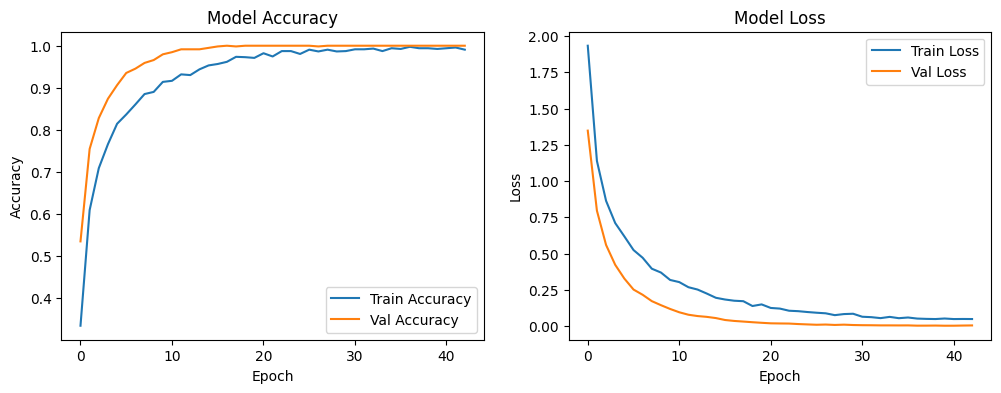

In [ ]:
plt.figure(figsize=(12,4))
# Plot accuracy

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluasi model
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 1.0000 - loss: 0.0029
Validation Accuracy: 1.0000


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

c:\Users\bayyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step


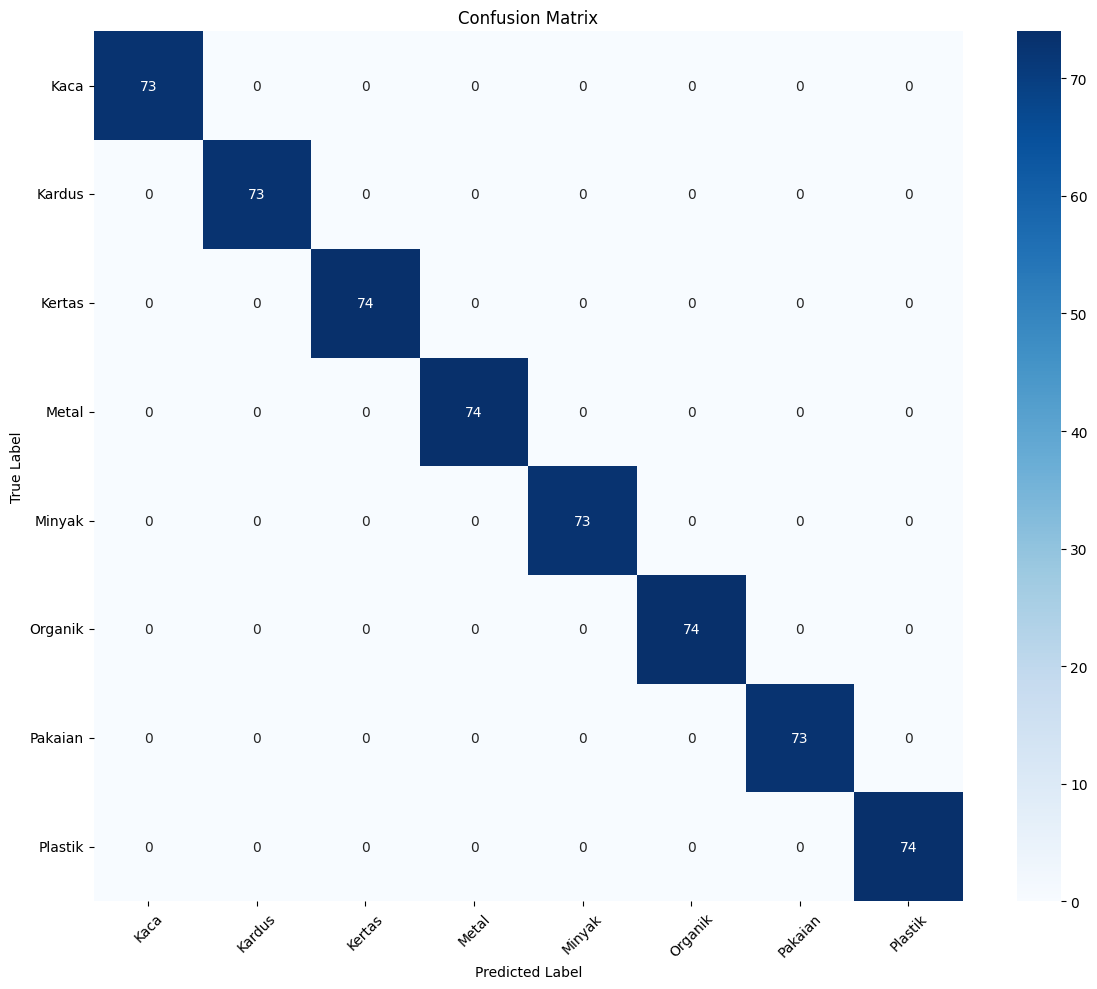

In [ ]:
y_true = test_df['Class'].values
y_pred_probs = model.predict(test_generator)
y_pred = y_pred_probs.argmax(axis=1)

class_labels = list(train_generator.class_indices.keys())
y_pred_labels = [class_labels[i] for i in y_pred]

cm = confusion_matrix(y_true, y_pred_labels, labels=class_labels)

# Langkah 3: Visualisasi dengan seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

In [ ]:
val_generator.reset()
preds = model.predict(val_generator)
y_pred = np.argmax(preds, axis=1)
y_true = val_generator.classes

all_class_labels = list(val_generator.class_indices.keys())

index_to_label = {v: k for k, v in val_generator.class_indices.items()}
unique_y_true_indices = np.unique(y_true)
filtered_class_labels = [index_to_label[i] for i in unique_y_true_indices]
print(classification_report(y_true, y_pred, target_names=filtered_class_labels, labels=unique_y_true_indices))

19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step
              precision    recall  f1-score   support

        Kaca       1.00      1.00      1.00        74
      Kardus       1.00      1.00      1.00        74
      Kertas       1.00      1.00      1.00        73
       Metal       1.00      1.00      1.00        73
      Minyak       1.00      1.00      1.00        73
     Organik       1.00      1.00      1.00        73
     Pakaian       1.00      1.00      1.00        74
     Plastik       1.00      1.00      1.00        73

    accuracy                           1.00       587
   macro avg       1.00      1.00      1.00       587
weighted avg       1.00      1.00      1.00       587



#### Testing Menggunakan Data Baru

In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:
def predict_image(img_path, model, class_indices, img_size=img_size):
    # Load dan preprocess gambar
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0 
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi
    pred = model.predict(img_array)
    class_id = np.argmax(pred)
    
    # Mapping index ke label
    labels = dict((v, k) for k, v in class_indices.items())
    predicted_label = labels[class_id]
    
    return predicted_label, pred[0][class_id]


In [ ]:
class_indices = train_generator.class_indices

In [ ]:
img_path = "sampah_classification/download (6).jpg"
label, confidence = predict_image(img_path, model, class_indices)
print(f"Prediksi: {label} (confidence: {confidence:.4f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
Prediksi: Kardus (confidence: 0.9939)


Yang masih kurang bisa diprediksi itu sampah plastik, tutup botol minuman

**Perbaikan**
tambah variasi dataset,
khusus untuk sampah plastik, dan metal

In [ ]:
model.save("model_densenet121.h5")

In [ ]:
model.save("model_densenet121.keras")

In [ ]:
import json

In [ ]:
with open('class_indices_densenet121.json', 'w') as f:
    json.dump(train_generator.class_indices, f)

In [8]:
import tensorflow as tf
tf.keras.models.load_model
from tensorflow.keras.preprocessing import image
import json
import numpy as np

In [49]:
model_load = tf.keras.models.load_model("model_densenet121.h5")

In [50]:
with open('class_indices_densenet121.json', 'r') as f:
    class_indices = json.load(f)

In [ ]:
 #Fungsi prediksi
def predict_image(img_path, model_load, class_indices, img_size=(224,224)):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0 
    img_array = np.expand_dims(img_array, axis=0)
    pred = model_load.predict(img_array)
    class_id = np.argmax(pred)
    labels = dict((v, k) for k, v in class_indices.items())
    predicted_label = labels[class_id]
    return predicted_label, pred[0][class_id]

# Contoh prediksi gambar baru
img_path = "sampah_classification/download (8).jpg"
label, confidence = predict_image(img_path, model_load, class_indices)
print(f"Prediksi: {label} (confidence: {confidence:.4f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediksi: Plastik (confidence: 0.6922)


### Model ke-Dua dengan tambahan dataset:
1. Plastik (Kantung Plastik, Tutup Botol & Galon)
2. Metal (Tutup Botol Aluminium & Tumpunkan Sampah Minuman Kaleng)

### Load Data

In [29]:
import pandas as pd

In [ ]:
data_dir_new = "sampah_classification/BurstNet/data_sampled"

In [31]:
print(os.listdir(data_dir_new))

['Kaca', 'Kardus', 'Kertas', 'Metal', 'Minyak', 'Organik', 'Pakaian', 'Plastik']


In [32]:
for folder_name in os.listdir(data_dir_new):
    folder_path = os.path.join(data_dir_new, folder_name)
    if os.path.isdir(folder_path):
        num_files = len(os.listdir(folder_path))
        print(f"{folder_name}: {num_files} files")

Kaca: 210 files
Kardus: 210 files
Kertas: 210 files
Metal: 218 files
Minyak: 209 files
Organik: 210 files
Pakaian: 210 files
Plastik: 246 files


In [33]:
folders = [f for f in os.listdir(data_dir_new) if os.path.isdir(os.path.join(data_dir_new, f))]
valid_exts = ('.jpg')

data = []
for folder in folders:
    folder_path = os.path.join(data_dir_new, folder)
    for img_file in os.listdir(folder_path):
        if img_file.lower().endswith(valid_exts):
            full_path = os.path.join(folder_path, img_file)
            if os.path.isfile(full_path):
                data.append({'Image': full_path, 'Class': folder})

df_images_baru = pd.DataFrame(data)
df_images_baru.tail()

,Image,Class
1718,C:/Users/bayyi/OneDrive/Documents/RESEARCH/sam...,Plastik
1719,C:/Users/bayyi/OneDrive/Documents/RESEARCH/sam...,Plastik
1720,C:/Users/bayyi/OneDrive/Documents/RESEARCH/sam...,Plastik
1721,C:/Users/bayyi/OneDrive/Documents/RESEARCH/sam...,Plastik
1722,C:/Users/bayyi/OneDrive/Documents/RESEARCH/sam...,Plastik


In [34]:
df_images_baru['Class'].value_counts()

Class
Plastik    246
Metal      218
Kaca       210
Kardus     210
Kertas     210
Organik    210
Pakaian    210
Minyak     209
Name: count, dtype: int64

### Split Data

In [35]:
from sklearn.model_selection import train_test_split
import os
from PIL import Image

In [36]:
train_df, test_df = train_test_split(
    df_images_baru, test_size=0.3, stratify=df_images_baru['Class'], random_state=42
)
val_df, test_df = train_test_split(
    train_df, test_size=0.5, stratify=train_df['Class'], random_state=42
) 

print(f"Train: {len(train_df)}")
print(f"Validation: {len(val_df)}")
print(f"Test: {len(test_df)}")

Train: 1206
Validation: 603
Test: 603


### Modelling

In [37]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,  ReduceLROnPlateau

In [38]:
img_size = (224,224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,         # rotasi acak
    width_shift_range=0.2,     # geser horizontal
    height_shift_range=0.2,    # geser vertikal
    shear_range=0.2,           # geser diagonal
    zoom_range=0.2,            # zoom acak
    horizontal_flip=True,      # flip horizontal
    fill_mode='nearest'        # pengisian piksel kosong
)

# Validasi dan test tidak perlu augmentasi
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generator
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='Image',    
    y_col='Class',        
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='Image',    
    y_col='Class',  
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='Image',    
    y_col='Class',  
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1206 validated image filenames belonging to 8 classes.
Found 603 validated image filenames belonging to 8 classes.
Found 603 validated image filenames belonging to 8 classes.


In [39]:
num_classes = len(train_generator.class_indices)
print("Jumlah kelas:", num_classes)

Jumlah kelas: 8


In [40]:
# Load base DenseNet121 tanpa top
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Bekukan SEMUA layer dulu
for layer in base_model.layers:
    layer.trainable = False

# Buka 100 layer terakhir untuk fine-tuning
for layer in base_model.layers[-100:]:
    layer.trainable = True


In [41]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,170,248 (27.35 MB)

 Trainable params: 2,081,096 (7.94 MB)

 Non-trainable params: 5,089,152 (19.41 MB)

In [42]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       
    patience=3,       
    min_lr=1e-6,   
    verbose=1
)

### Training

In [43]:
history = model.fit(
    train_generator,
    epochs=45,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

c:\Users\bayyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/45
38/38 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.2624 - loss: 2.2940 - val_accuracy: 0.5954 - val_loss: 1.2278 - learning_rate: 1.0000e-04
Epoch 2/45
38/38 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.5465 - loss: 1.3092 - val_accuracy: 0.7496 - val_loss: 0.7950 - learning_rate: 1.0000e-04
Epoch 3/45
38/38 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.6962 - loss: 0.9247 - val_accuracy: 0.8226 - val_loss: 0.5982 - learning_rate: 1.0000e-04
Epoch 4/45
38/38 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - accuracy: 0.7256 - loss: 0.8114 - val_accuracy: 0.8673 - val_loss: 0.4584 - learning_rate: 1.0000e-04
Epoch 5/45
38/38 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - accuracy: 0.8025 - loss: 0.6641 - val_accuracy: 0.9005 - val_loss: 0.3584 - learning_rate: 1.0000e-04
Epoch 6/45
38/38 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - accuracy: 0.8433 - loss: 0.5378 - val_accuracy: 0.9270 - val_loss: 0.2821 - learning_rate: 1.0000e-04
Epoch 7/45
38/38 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.8589 

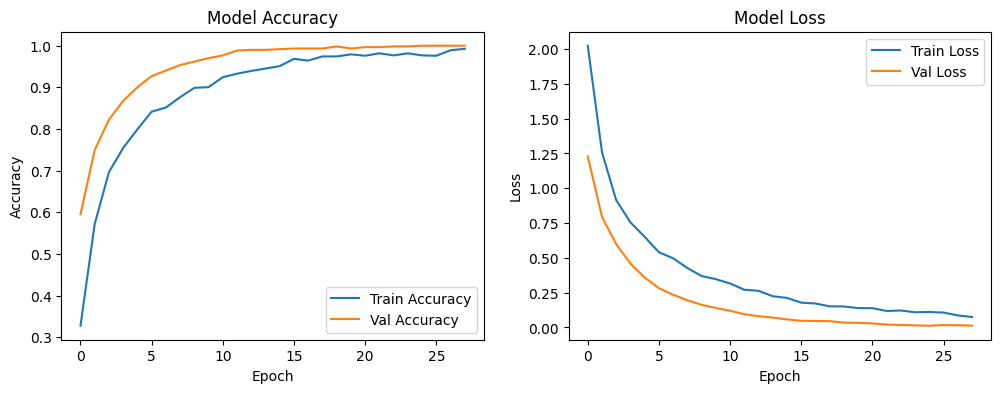

In [44]:
plt.figure(figsize=(12,4))
# Plot accuracy

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluation

In [45]:
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 1.0000 - loss: 0.0155
Validation Accuracy: 1.0000


In [46]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

c:\Users\bayyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step


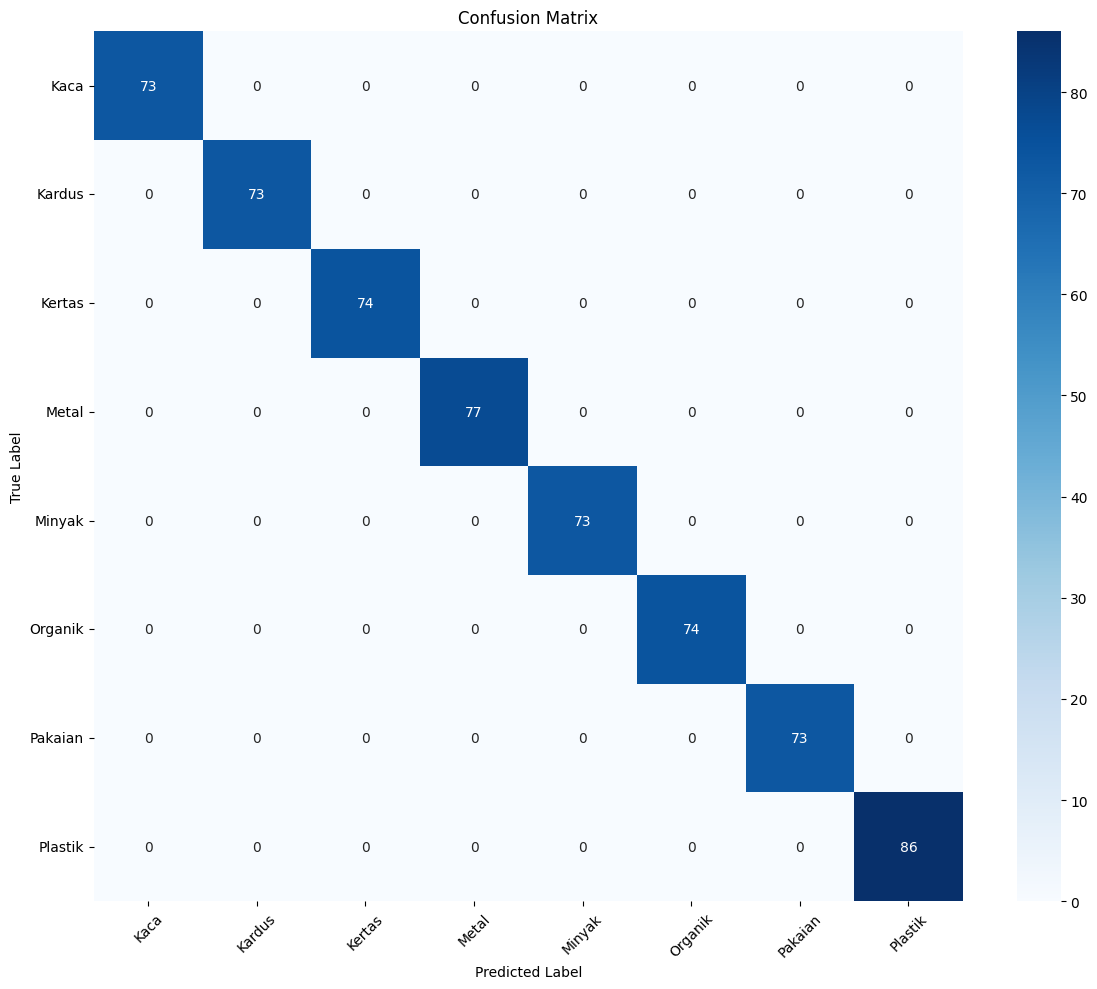

In [47]:
y_true = test_df['Class'].values
y_pred_probs = model.predict(test_generator)
y_pred = y_pred_probs.argmax(axis=1)

class_labels = list(train_generator.class_indices.keys())
y_pred_labels = [class_labels[i] for i in y_pred]

cm = confusion_matrix(y_true, y_pred_labels, labels=class_labels)

# Langkah 3: Visualisasi dengan seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [48]:
val_generator.reset()
preds = model.predict(val_generator)
y_pred = np.argmax(preds, axis=1)
y_true = val_generator.classes

all_class_labels = list(val_generator.class_indices.keys())

index_to_label = {v: k for k, v in val_generator.class_indices.items()}
unique_y_true_indices = np.unique(y_true)
filtered_class_labels = [index_to_label[i] for i in unique_y_true_indices]
print(classification_report(y_true, y_pred, target_names=filtered_class_labels, labels=unique_y_true_indices))

19/19 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step
              precision    recall  f1-score   support

        Kaca       1.00      1.00      1.00        74
      Kardus       1.00      1.00      1.00        74
      Kertas       1.00      1.00      1.00        73
       Metal       1.00      1.00      1.00        76
      Minyak       1.00      1.00      1.00        73
     Organik       1.00      1.00      1.00        73
     Pakaian       1.00      1.00      1.00        74
     Plastik       1.00      1.00      1.00        86

    accuracy                           1.00       603
   macro avg       1.00      1.00      1.00       603
weighted avg       1.00      1.00      1.00       603



### Testing Menggunakan Data Baru

In [52]:
def predict_image(img_path, model, class_indices, img_size=img_size):
    # Load dan preprocess gambar
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0 
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi
    pred = model.predict(img_array)
    class_id = np.argmax(pred)
    
    # Mapping index ke label
    labels = dict((v, k) for k, v in class_indices.items())
    predicted_label = labels[class_id]
    
    return predicted_label, pred[0][class_id]


In [53]:
class_indices = train_generator.class_indices

In [ ]:
img_path = "sampah_classification/download (4).jpg"
label, confidence = predict_image(img_path, model, class_indices)
print(f"Prediksi: {label} (confidence: {confidence:.4f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Prediksi: Metal (confidence: 0.9975)


In [60]:
model.save('model_denseNet_v2.h5')

In [61]:
model.save('model_denseNet_v2.keras')